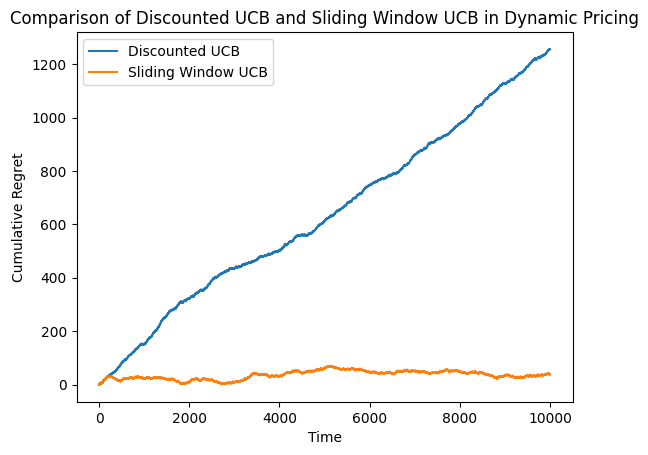

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class DynamicPricingEnv:
    def __init__(self, prices, change_points, reward_probabilities):
        self.prices = prices
        self.change_points = change_points
        self.reward_probabilities = reward_probabilities
        self.current_phase = 0
        self.t = 0

    def step(self, price_index):
        if self.t in self.change_points:
            self.current_phase = min(self.current_phase + 1, len(self.reward_probabilities) - 1)
        self.t += 1
        return np.random.rand() < self.reward_probabilities[self.current_phase][price_index]

    def reset(self):
        self.current_phase = 0
        self.t = 0

class DiscountedUCB:
    def __init__(self, n_arms, gamma=0.99):
        self.n_arms = n_arms
        self.gamma = gamma
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        total = np.sum(self.counts)
        ucb_values = (self.values / self.counts) + np.sqrt((2 * np.log(total)) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts *= self.gamma
        self.values *= self.gamma
        self.counts[arm] += 1
        self.values[arm] += reward

class SlidingWindowUCB:
    def __init__(self, n_arms, window_size=50):
        self.n_arms = n_arms
        self.window_size = window_size
        self.rewards = [[] for _ in range(n_arms)]

    def select_arm(self):
        for arm in range(self.n_arms):
            if len(self.rewards[arm]) == 0:
                return arm
        total_pulls = sum(len(rewards) for rewards in self.rewards)
        ucb_values = []
        for arm in range(self.n_arms):
            cnt = len(self.rewards[arm])
            avg = sum(self.rewards[arm]) / cnt
            ucb = avg + np.sqrt((2 * np.log(total_pulls)) / cnt)
            ucb_values.append(ucb)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.rewards[arm].append(reward)
        if len(self.rewards[arm]) > self.window_size:
            self.rewards[arm].pop(0)

# Experiment Setup
prices = [5, 10, 15, 20]
change_points = [2000, 4000, 6000, 8000]
reward_probabilities = [
    [0.3, 0.5, 0.2, 0.1],  # Phase 1
    [0.2, 0.6, 0.3, 0.15], # Phase 2
    [0.1, 0.4, 0.5, 0.3],  # Phase 3
    [0.25, 0.35, 0.3, 0.2], # Phase 4
    [0.15, 0.5, 0.25, 0.4]  # Phase 5
]

env = DynamicPricingEnv(prices, change_points, reward_probabilities)
d_ucb = DiscountedUCB(len(prices))
sw_ucb = SlidingWindowUCB(len(prices))

T = 10000  # Total time steps
regrets_d = []
regrets_sw = []

for t in range(T):
    # Discounted UCB
    arm_d = d_ucb.select_arm()
    reward_d = env.step(arm_d)
    d_ucb.update(arm_d, reward_d)
    regrets_d.append(max(reward_probabilities[env.current_phase]) - reward_d)

    # Sliding Window UCB
    arm_sw = sw_ucb.select_arm()
    reward_sw = env.step(arm_sw)
    sw_ucb.update(arm_sw, reward_sw)
    regrets_sw.append(max(reward_probabilities[env.current_phase]) - reward_sw)

# Plot Regrets
plt.plot(np.cumsum(regrets_d), label='Discounted UCB')
plt.plot(np.cumsum(regrets_sw), label='Sliding Window UCB')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of Discounted UCB and Sliding Window UCB in Dynamic Pricing")
plt.show()